# Kriging Interpolation of Yield Data

## Overview

This notebook performs **spatial interpolation (kriging)** on harvest yield data to:
1. Load validated point data from GeoPackage (from 02_Spatial_Yield_Analysis)
2. Apply manual exclusion filters for problematic data (e.g., harvester edge effects)
3. Fit variogram models to understand spatial correlation
4. Perform kriging interpolation with two strategies:
   - **Combined model**: All years together (using normalized relative yield)
   - **Separate models**: Individual kriging per year
5. Compare results and create interpolated yield surfaces

## Why Two Approaches?

- **Combined (all years)**: Relative yield is already normalized to crop-year averages, so spatial patterns may be consistent across years. More data points = more robust variogram.
- **Separate (per year)**: Each year may have unique weather/management effects that create different spatial structures.

## Output

- Variogram plots showing spatial correlation
- Interpolated yield surfaces (rasters)
- Cross-validation statistics (RMSE, MAE)
- Comparison of both kriging strategies

In [2]:
# Section 1: Import Required Libraries

from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import logging

# Spatial analysis
from scipy.spatial import distance_matrix
from sklearn.model_selection import KFold

# Kriging libraries
try:
    import pykrige
    from pykrige.ok import OrdinaryKriging
    from pykrige.uk import UniversalKriging
    HAS_PYKRIGE = True
except ImportError:
    HAS_PYKRIGE = False
    print("⚠ PyKrige not installed: pip install pykrige")

# Raster export
try:
    import rasterio
    from rasterio.transform import from_bounds
    HAS_RASTERIO = True
except ImportError:
    HAS_RASTERIO = False
    print("⚠ Rasterio not installed: pip install rasterio")

# Setup logging
logger = logging.getLogger('03_Kriging_Interpolation')
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

print("✓ Libraries loaded successfully")
print(f"  PyKrige available: {HAS_PYKRIGE}")
print(f"  Rasterio available: {HAS_RASTERIO}")

if not HAS_PYKRIGE:
    print("\n❌ PyKrige is required for this notebook. Install with: pip install pykrige")

✓ Libraries loaded successfully
  PyKrige available: True
  Rasterio available: True


## Configuration & Data Paths

Set paths to load the GeoPackage from the previous notebook.

In [3]:
# Configuration: Set paths

# Project root
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / 'data'
SPATIAL_DIR = DATA_DIR / 'spatial_analysis'

# Input: GeoPackage from 02_Spatial_Yield_Analysis
GEOPACKAGE_PATH = SPATIAL_DIR / 'yield_points_utm.gpkg'

# Optional: Field polygons (GeoJSON) for polygon-based clipping & CompositeID grouping
FIELDS_GEOJSON_PATH = DATA_DIR / 'harvest_fields.geojson'  # GeoJSON is WGS84 by spec; will be reprojected
FIELD_ID_ATTR = 'CompositeID'  # attribute in polygons identifying composite ID
YEAR_TO_RUN = 2025             # year to process (e.g., problematic 'import' names)

# Output directory for kriging results
KRIGING_OUTPUT_DIR = DATA_DIR / 'kriging_results'
KRIGING_OUTPUT_DIR.mkdir(exist_ok=True)

# Kriging parameters
GRID_RESOLUTION = 2  # meters (2m grid for interpolation)
VARIOGRAM_MODELS = ['spherical', 'exponential', 'gaussian']  # Models to test
N_LAGS = 15  # Number of lag bins for variogram
MAX_LAG_DISTANCE = 200  # meters - max distance for variogram pairs (given ~17m point spacing)

# Per-field kriging configuration
PER_FIELD_ENABLED = True  # enable per-field kriging workflow
FIELDS_TO_RUN = None      # set to a list like ['Field_A', 'Field_B'] to limit; None runs all
DEFAULT_FIELD_MODEL = 'exponential'  # use exponential model per your findings

logger.info(f"Project root: {PROJECT_ROOT}")
logger.info(f"Input GeoPackage: {GEOPACKAGE_PATH}")
logger.info(f"Output directory: {KRIGING_OUTPUT_DIR}")
logger.info(f"Grid resolution: {GRID_RESOLUTION}m")
logger.info(f"Max lag distance for variogram: {MAX_LAG_DISTANCE}m")
logger.info(f"Per-field kriging enabled: {PER_FIELD_ENABLED}")
if FIELDS_TO_RUN:
    logger.info(f"Fields to run: {FIELDS_TO_RUN}")
else:
    logger.info("Fields to run: ALL")

# Log polygon config
logger.info(f"Fields GeoJSON: {FIELDS_GEOJSON_PATH}")
logger.info(f"Field ID attribute: {FIELD_ID_ATTR}")
logger.info(f"Year to run (CompositeID workflow): {YEAR_TO_RUN}")


Project root: /Users/holmes/local_dev/agri_analysis
Input GeoPackage: /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.gpkg
Output directory: /Users/holmes/local_dev/agri_analysis/data/kriging_results
Grid resolution: 2m
Max lag distance for variogram: 200m
Per-field kriging enabled: True
Fields to run: ALL
Fields GeoJSON: /Users/holmes/local_dev/agri_analysis/data/harvest_fields.geojson
Field ID attribute: CompositeID
Year to run (CompositeID workflow): 2025


## Section 2: Load Yield Data from GeoPackage

Load the validated and normalized yield points with UTM coordinates.

In [4]:
# Load GeoPackage data
logger.info(f"Loading data from {GEOPACKAGE_PATH}...")

if not GEOPACKAGE_PATH.exists():
    raise FileNotFoundError(
        f"GeoPackage not found: {GEOPACKAGE_PATH}\n"
        "Please run 02_Spatial_Yield_Analysis.ipynb first to generate the data."
    )

gdf = gpd.read_file(GEOPACKAGE_PATH)

logger.info(f"Loaded {len(gdf):,} points")
logger.info(f"CRS: {gdf.crs}")

print("\n" + "="*80)
print("LOADED DATA SUMMARY")
print("="*80)
print(f"Total points: {len(gdf):,}")
print(f"CRS: {gdf.crs}")
print(f"\nCrops: {gdf['Crop'].unique()}")
print(f"Years: {sorted(gdf['Year'].unique())}")
print(f"Fields: {gdf['Field'].nunique()} unique fields")

print(f"\nColumns available:")
for col in gdf.columns:
    if col != 'geometry':
        print(f"  - {col}")

print(f"\nRelative yield statistics:")
print(f"  Mean: {gdf['relative_yield'].mean():.3f}")
print(f"  Std: {gdf['relative_yield'].std():.3f}")
print(f"  Range: [{gdf['relative_yield'].min():.3f}, {gdf['relative_yield'].max():.3f}]")

# Show sample
print(f"\nSample data:")
print(gdf[['x_utm', 'y_utm', 'Crop', 'Year', 'yield_t_ha', 'relative_yield']].head())

Loading data from /Users/holmes/local_dev/agri_analysis/data/spatial_analysis/yield_points_utm.gpkg...
Loaded 593,596 points
CRS: EPSG:25832



LOADED DATA SUMMARY
Total points: 593,596
CRS: EPSG:25832

Crops: ['VB - Vårbyg' 'RG - Rajgræs' 'RA - Raps / rybs' 'HV - Hvede'
 'VIB - Vinterbyg' 'KLL - Kløver / lucerne']
Years: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Fields: 28 unique fields

Columns available:
  - x_utm
  - y_utm
  - Crop
  - Year
  - Field
  - CompositeTLGID
  - yield_t_ha
  - avg_yield_t_ha
  - relative_yield
  - latitude
  - longitude
  - time_stamp
  - fugtighed

Relative yield statistics:
  Mean: 1.000
  Std: 0.394
  Range: [0.002, 39.513]

Sample data:
           x_utm         y_utm         Crop  Year  yield_t_ha  relative_yield
0  684762.512894  6.165175e+06  VB - Vårbyg  2022       5.586        0.808531
1  684760.956886  6.165175e+06  VB - Vårbyg  2022       5.586        0.808531
2  684758.242243  6.165175e+06  VB - Vårbyg  2022       6.462        0.935325
3  684755.745038  6.165175e+06  VB - Vårbyg  2022       2.678        0.387620
4  684754.024144  6.165175e+06  V

## Section 3: Manual Exclusion of Problematic Data

Add a filter to exclude problematic points (e.g., harvester edge effects, calibration errors).

You can modify the exclusion criteria below based on visual inspection of the maps.

In [5]:
# Manual exclusion filters
# Modify these criteria based on data quality inspection

# Initialize exclude flag (all points included by default)
gdf['exclude'] = False

# Example exclusion criteria:
# 1. Extreme outliers (relative yield > 3 std from mean)
mean_ry = gdf['relative_yield'].mean()
std_ry = gdf['relative_yield'].std()
outlier_threshold = 3
outliers = (gdf['relative_yield'] < mean_ry - outlier_threshold * std_ry) | \
           (gdf['relative_yield'] > mean_ry + outlier_threshold * std_ry)
gdf.loc[outliers, 'exclude'] = True

logger.info(f"Excluded {outliers.sum()} extreme outliers (>{outlier_threshold} std from mean)")

# 2. Manual geographic exclusion (example: exclude specific field or area)
# Uncomment and modify as needed:
# gdf.loc[gdf['Field'] == 'Problematic_Field_Name', 'exclude'] = True

# 3. You can also exclude based on spatial patterns (e.g., field edges)
# This would require defining boundaries - can be added later

# Filter to valid points for kriging
gdf_valid = gdf[~gdf['exclude']].copy()

print("\n" + "="*80)
print("EXCLUSION SUMMARY")
print("="*80)
print(f"Original points: {len(gdf):,}")
print(f"Excluded points: {gdf['exclude'].sum():,} ({100*gdf['exclude'].sum()/len(gdf):.1f}%)")
print(f"Valid points for kriging: {len(gdf_valid):,}")

print(f"\nValid points by Crop and Year:")
print(gdf_valid.groupby(['Crop', 'Year']).size())

print(f"\n💡 Tip: To manually exclude more points, modify the exclusion criteria above.")
print(f"   You can exclude by Field name, coordinate ranges, or other attributes.")

Excluded 2499 extreme outliers (>3 std from mean)



EXCLUSION SUMMARY
Original points: 593,596
Excluded points: 2,499 (0.4%)
Valid points for kriging: 591,097

Valid points by Crop and Year:
Crop                    Year
HV - Hvede              2021    20500
                        2022    36362
                        2023    29868
                        2024    39214
                        2025    45156
KLL - Kløver / lucerne  2022    11639
RA - Raps / rybs        2021    13909
                        2022     2224
                        2023    15990
                        2024    27048
                        2025    10286
RG - Rajgræs            2021    17311
                        2022     3472
                        2023    50144
                        2024    87572
                        2025    43028
VB - Vårbyg             2021     8296
                        2022    19326
                        2023    11954
                        2024    27222
                        2025    32934
VIB - Vinterbyg         2022    2

## Section 4: Variogram Analysis
Analyze spatial autocorrelation by computing and plotting experimental variograms.
We fit variogram parameters inside OrdinaryKriging (spherical/exponential/gaussian) and report the fitted sill, range, and nugget. Results are also written to CSV in data/kriging_results for traceability.

## Section 4b: Variogram Analysis - By Field (relocated)

Per-field semivariogram analysis now happens alongside the CompositeID polygon workflow in Section 6b so that it uses the GeoJSON intersection. See Section 6b for the updated code and plots/CSV outputs.

Dataset has 591,097 points - subsampling to 20,000 for variogram
(Variogram doesn't need all points, random subsample is representative)
Computing variogram for 20,000 points...
  Fitting spherical model...



VARIOGRAM ANALYSIS: ALL YEARS COMBINED

⚠ Using 20,000 / 591,097 points for variogram (random subsample)
  This prevents memory issues while preserving spatial structure


  Fitting exponential model...


KeyboardInterrupt: 

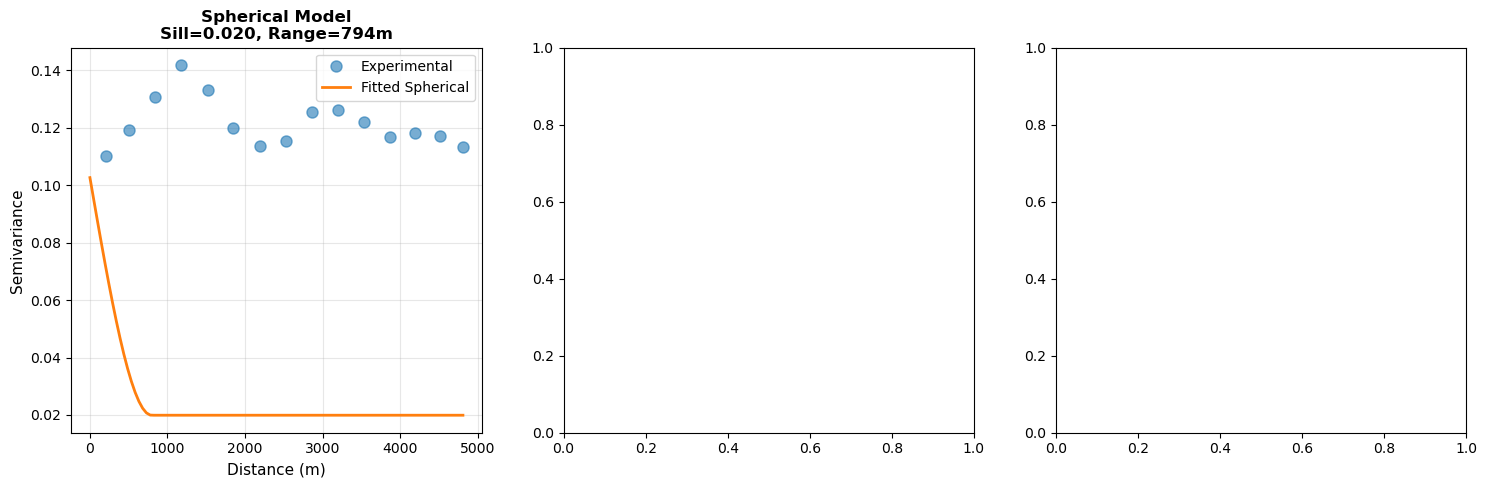

In [ ]:
# Variogram analysis: Combined (all years)
# Note: Variogram computation can be memory-intensive for large datasets
# We subsample if needed to avoid kernel crashes

def compute_spherical_variogram(params, distances):
    """Compute spherical variogram model"""
    sill, range_val, nugget = params
    h = distances / range_val
    # Spherical model: γ(h) = nugget + (sill-nugget) * (1.5*h - 0.5*h³) for h <= 1
    result = np.zeros_like(distances)
    mask = h <= 1.0
    result[mask] = nugget + (sill - nugget) * (1.5 * h[mask] - 0.5 * h[mask]**3)
    result[~mask] = sill
    return result

def compute_exponential_variogram(params, distances):
    """Compute exponential variogram model"""
    sill, range_val, nugget = params
    return nugget + (sill - nugget) * (1 - np.exp(-3 * distances / range_val))

def compute_gaussian_variogram(params, distances):
    """Compute gaussian variogram model"""
    sill, range_val, nugget = params
    return nugget + (sill - nugget) * (1 - np.exp(-3 * (distances / range_val)**2))

if not HAS_PYKRIGE:
    print("⚠ Skipping variogram analysis - PyKrige not installed")
else:
    print("\n" + "="*80)
    print("VARIOGRAM ANALYSIS: ALL YEARS COMBINED")
    print("="*80)
    
    # Extract coordinates and values
    x_full = gdf_valid['x_utm'].values
    y_full = gdf_valid['y_utm'].values
    z_full = gdf_valid['relative_yield'].values
    
    # Subsample if dataset is very large (to avoid memory issues)
    MAX_VARIOGRAM_POINTS = 20000  # Reduced for faster computation
    
    if len(z_full) > MAX_VARIOGRAM_POINTS:
        logger.warning(f"Dataset has {len(z_full):,} points - subsampling to {MAX_VARIOGRAM_POINTS:,} for variogram")
        logger.warning(f"(Variogram doesn't need all points, random subsample is representative)")
        
        # Random subsample
        np.random.seed(42)
        subsample_idx = np.random.choice(len(z_full), size=MAX_VARIOGRAM_POINTS, replace=False)
        x = x_full[subsample_idx]
        y = y_full[subsample_idx]
        z = z_full[subsample_idx]
        
        print(f"\n⚠ Using {len(z):,} / {len(z_full):,} points for variogram (random subsample)")
        print(f"  This prevents memory issues while preserving spatial structure")
    else:
        x = x_full
        y = y_full
        z = z_full
    
    logger.info(f"Computing variogram for {len(z):,} points...")
    
    # Test different variogram models
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    variogram_params = {}
    
    for idx, model in enumerate(VARIOGRAM_MODELS):
        ax = axes[idx]
        
        try:
            # Create kriging object to extract variogram
            logger.info(f"  Fitting {model} model...")
            ok = OrdinaryKriging(
                x, y, z,
                variogram_model=model,
                nlags=N_LAGS,
                enable_plotting=False,
                verbose=False
            )
            
            # Extract variogram parameters
            variogram_params[model] = {
                'model': model,
                'sill': ok.variogram_model_parameters[0],
                'range': ok.variogram_model_parameters[1],
                'nugget': ok.variogram_model_parameters[2]
            }
            
            # Plot experimental variogram (filter to MAX_LAG_DISTANCE to reduce noise)
            lags = ok.lags
            semivariance = ok.semivariance
            valid_lags = lags <= MAX_LAG_DISTANCE
            
            ax.plot(lags[valid_lags], semivariance[valid_lags], 'o', label='Experimental', markersize=8, alpha=0.6)
            
            # Plot fitted model using manual computation (constrain to MAX_LAG_DISTANCE)
            lag_range = np.linspace(0, min(lags.max(), MAX_LAG_DISTANCE), 100)
            params = ok.variogram_model_parameters
            
            if model == 'spherical':
                model_values = compute_spherical_variogram(params, lag_range)
            elif model == 'exponential':
                model_values = compute_exponential_variogram(params, lag_range)
            elif model == 'gaussian':
                model_values = compute_gaussian_variogram(params, lag_range)
            
            ax.plot(lag_range, model_values, '-', label=f'Fitted {model.capitalize()}', linewidth=2)
            
            # Formatting
            ax.set_xlabel('Distance (m)', fontsize=11)
            ax.set_ylabel('Semivariance', fontsize=11)
            ax.set_title(f'{model.capitalize()} Model (max lag {MAX_LAG_DISTANCE}m)\nSill={variogram_params[model]["sill"]:.3f}, Range={variogram_params[model]["range"]:.0f}m',
                        fontsize=12, fontweight='bold')
            ax.set_xlim(0, MAX_LAG_DISTANCE)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        except MemoryError as e:
            logger.error(f"Memory error for {model} model - try reducing MAX_VARIOGRAM_POINTS")
            ax.text(0.5, 0.5, f'Memory Error\n{model.capitalize()} model\nReduce data size',
                   ha='center', va='center', fontsize=12, color='red')
            ax.set_xlabel('Distance (m)', fontsize=11)
            ax.set_ylabel('Semivariance', fontsize=11)
        except Exception as e:
            logger.error(f"Error fitting {model} model: {str(e)}")
            ax.text(0.5, 0.5, f'Error\n{model.capitalize()} model\n{str(e)[:40]}',
                   ha='center', va='center', fontsize=10, color='red')
            ax.set_xlabel('Distance (m)', fontsize=11)
            ax.set_ylabel('Semivariance', fontsize=11)
    
    plt.suptitle(f'Variogram Models - All Years Combined (Relative Yield)\nUsing {len(z):,} points (max lag distance: {MAX_LAG_DISTANCE}m)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(KRIGING_OUTPUT_DIR / 'variogram_combined.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    if variogram_params:
        print(f"\nVariogram parameters:")
        for model, params in variogram_params.items():
            print(f"  {model.capitalize()}:")
            print(f"    Sill: {params['sill']:.3f}")
            print(f"    Range: {params['range']:.0f} m")
            print(f"    Nugget: {params['nugget']:.3f}")
        
        # Save parameters to CSV for traceability
        import pandas as pd
        pd.DataFrame.from_dict(variogram_params, orient='index').to_csv(KRIGING_OUTPUT_DIR / 'variogram_params_combined.csv')
        print(f"\nSaved variogram parameters to {KRIGING_OUTPUT_DIR / 'variogram_params_combined.csv'}")
        
        print(f"\n💡 Interpretation:")
        if 'spherical' in variogram_params:
            print(f"   - Range indicates the distance of spatial influence (~{variogram_params['spherical']['range']:.0f}m)")
        print(f"   - Nugget shows measurement error + micro-scale variation")
        print(f"   - Lower nugget = more reliable measurements")
    else:

        print("\n❌ All variogram models failed - check memory and data quality")        print("\n❌ All variogram models failed - check memory and data quality")

In [ ]:
# Variogram analysis: Separate by year

if not HAS_PYKRIGE:
    print("⚠ Skipping variogram analysis - PyKrige not installed")
else:
    print("\n" + "="*80)
    print("VARIOGRAM ANALYSIS: SEPARATE BY YEAR")
    print("="*80)
    
    years = sorted(gdf_valid['Year'].unique())
    n_years = len(years)
    
    fig, axes = plt.subplots(1, n_years, figsize=(6*n_years, 5))
    if n_years == 1:
        axes = [axes]
    
    variogram_params_yearly = {}
    
    for idx, year in enumerate(years):
        ax = axes[idx]
        
        try:
            # Filter data for this year
            year_data = gdf_valid[gdf_valid['Year'] == year]
            
            x = year_data['x_utm'].values
            y = year_data['y_utm'].values
            z = year_data['relative_yield'].values
            
            logger.info(f"Computing variogram for {year}: {len(z)} points")
            
            # Use spherical model (typically good for agricultural data)
            ok = OrdinaryKriging(
                x, y, z,
                variogram_model='spherical',
                nlags=N_LAGS,
                enable_plotting=False,
                verbose=False
            )
            
            # Store parameters
            variogram_params_yearly[year] = {
                'year': year,
                'sill': ok.variogram_model_parameters[0],
                'range': ok.variogram_model_parameters[1],
                'nugget': ok.variogram_model_parameters[2]
            }
            
            # Plot (filter to MAX_LAG_DISTANCE to reduce noise)
            lags = ok.lags
            semivariance = ok.semivariance
            valid_lags = lags <= MAX_LAG_DISTANCE
            
            ax.plot(lags[valid_lags], semivariance[valid_lags], 'o', label='Experimental', markersize=8, alpha=0.6)
            
            # Fitted model using manual computation (constrain to MAX_LAG_DISTANCE)
            lag_range = np.linspace(0, min(lags.max(), MAX_LAG_DISTANCE), 100)
            params = ok.variogram_model_parameters
            model_values = compute_spherical_variogram(params, lag_range)
            ax.plot(lag_range, model_values, '-', label='Fitted Spherical', linewidth=2)
            
            # Formatting
            ax.set_xlabel('Distance (m)', fontsize=11)
            ax.set_title(f'{year}\n{len(z):,} points, Range={variogram_params_yearly[year]["range"]:.0f}m, max lag {MAX_LAG_DISTANCE}m',
            ax.set_title(f'{year}\n{len(z):,} points, Range={variogram_params_yearly[year]["range"]:.0f}m',
            ax.set_xlim(0, MAX_LAG_DISTANCE)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        except Exception as e:
            logger.error(f"Error for {year}: {str(e)}")
            ax.text(0.5, 0.5, f'Error\n{year}\n{str(e)[:30]}',
                   ha='center', va='center', fontsize=10, color='red')
            ax.set_xlabel('Distance (m)', fontsize=11)
            ax.set_ylabel('Semivariance', fontsize=11)
    
    plt.suptitle('Variogram Models by Year (Spherical)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(KRIGING_OUTPUT_DIR / 'variogram_by_year.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    if variogram_params_yearly:
        print(f"\nVariogram parameters by year:")
        for year, params in variogram_params_yearly.items():
            print(f"  {year}:")
            print(f"    Sill: {params['sill']:.3f}")
            print(f"    Range: {params['range']:.0f} m")
            print(f"    Nugget: {params['nugget']:.3f}")
        
        # Save parameters to CSV for traceability
        pd.DataFrame.from_dict(variogram_params_yearly, orient='index').to_csv(KRIGING_OUTPUT_DIR / 'variogram_params_by_year.csv')
        print(f"\nSaved yearly variogram parameters to {KRIGING_OUTPUT_DIR / 'variogram_params_by_year.csv'}")
        
        print(f"\n💡 Compare ranges across years to see if spatial structure is consistent.")
    else:

        print(f"\n❌ Variogram analysis failed for all years")        print(f"\n❌ Variogram analysis failed for all years")

## Section 5: Kriging Interpolation - Combined Model

Perform kriging using all years combined. This assumes spatial patterns are similar across years (normalized by relative yield).

In [ ]:
# Kriging: All years combined
# Note: Kriging all 500k+ points can be slow - consider spatial thinning if needed

if not HAS_PYKRIGE:
    print("⚠ Skipping kriging - PyKrige not installed")
else:
    print("\n" + "="*80)
    print("KRIGING INTERPOLATION: ALL YEARS COMBINED")
    print("="*80)
    
    # Extract data
    x = gdf_valid['x_utm'].values
    y = gdf_valid['y_utm'].values
    z = gdf_valid['relative_yield'].values
    
    print(f"Dataset: {len(z):,} points")
    
    # Option: Spatial thinning for very large datasets
    # Uncomment if kriging is too slow:
    # MAX_KRIGING_POINTS = 100000
    # if len(z) > MAX_KRIGING_POINTS:
    #     print(f"⚠ Thinning to {MAX_KRIGING_POINTS:,} points for faster kriging")
    #     thin_idx = np.random.choice(len(z), size=MAX_KRIGING_POINTS, replace=False)
    #     x, y, z = x[thin_idx], y[thin_idx], z[thin_idx]
    
    # Define grid extent
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    # Create grid
    grid_x = np.arange(x_min, x_max, GRID_RESOLUTION)
    grid_y = np.arange(y_min, y_max, GRID_RESOLUTION)
    
    logger.info(f"Grid size: {len(grid_x)} x {len(grid_y)} = {len(grid_x)*len(grid_y):,} cells")
    logger.info(f"Performing ordinary kriging with spherical variogram...")
    logger.info(f"⚠ This may take several minutes with {len(z):,} points...")
    
    try:
        # Perform kriging
        ok_combined = OrdinaryKriging(
            x, y, z,
            variogram_model='spherical',
            nlags=N_LAGS,
            enable_plotting=False,
            verbose=True
        )
        
        # Execute interpolation
        print(f"\nExecuting kriging interpolation...")
        z_pred, ss_pred = ok_combined.execute('grid', grid_x, grid_y)
        
        logger.info("Kriging complete!")
        
        # Plot results
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        
        # Predicted values
        ax = axes[0]
        im1 = ax.imshow(
            z_pred,
            extent=[x_min, x_max, y_min, y_max],
            origin='lower',
            cmap='RdYlGn',
            vmin=0.6,
            vmax=1.4,
            aspect='auto'
        )
        ax.scatter(x[::100], y[::100], c='black', s=1, alpha=0.2, label=f'Data points (every 100th)')
        ax.set_xlabel('UTM X (m)', fontsize=11)
        ax.set_ylabel('UTM Y (m)', fontsize=11)
        ax.set_title(f'Kriging Prediction\n(Relative Yield, {len(z):,} points)', fontsize=12, fontweight='bold')
        cbar1 = plt.colorbar(im1, ax=ax)
        cbar1.set_label('Relative Yield', fontsize=10)
        ax.legend()
        
        # Prediction variance
        ax = axes[1]
        im2 = ax.imshow(
            ss_pred,
            extent=[x_min, x_max, y_min, y_max],
            origin='lower',
            cmap='viridis',
            aspect='auto'
        )
        ax.scatter(x[::100], y[::100], c='white', s=1, alpha=0.3, label='Data points (every 100th)')
        ax.set_xlabel('UTM X (m)', fontsize=11)
        ax.set_ylabel('UTM Y (m)', fontsize=11)
        ax.set_title('Kriging Variance\n(Prediction Uncertainty)', fontsize=12, fontweight='bold')
        cbar2 = plt.colorbar(im2, ax=ax)
        cbar2.set_label('Variance', fontsize=10)
        ax.legend()
        
        plt.suptitle('Kriging Results - All Years Combined', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(KRIGING_OUTPUT_DIR / 'kriging_combined.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Kriging interpolation complete")
        print(f"  Grid resolution: {GRID_RESOLUTION}m")
        print(f"  Output grid: {len(grid_x)} x {len(grid_y)}")
        print(f"  Mean predicted relative yield: {np.nanmean(z_pred):.3f}")
        print(f"  Mean kriging variance: {np.nanmean(ss_pred):.3f}")
        
        # Save results
        kriging_combined_results = {
            'z_pred': z_pred,
            'ss_pred': ss_pred,
            'grid_x': grid_x,
            'grid_y': grid_y,
            'ok_model': ok_combined
        }
        
    except MemoryError as e:
        print(f"\n❌ MEMORY ERROR: Dataset too large for kriging ({len(z):,} points)")
        print(f"   Solutions:")
        print(f"   1. Enable spatial thinning (uncomment code above)")
        print(f"   2. Increase grid resolution (e.g., GRID_RESOLUTION = 20)")
        print(f"   3. Use yearly kriging instead (fewer points per model)")
        print(f"   4. Exclude more data in Section 3")
        
    except Exception as e:
        print(f"\n❌ ERROR during kriging: {str(e)}")
        print(f"   Check error details above for diagnosis")
        import traceback
        traceback.print_exc()

## Section 6: Kriging Interpolation - Separate by Year

Perform separate kriging for each year to capture year-specific spatial patterns.

In [ ]:
# Kriging: Separate models by year

if not HAS_PYKRIGE:
    print("⚠ Skipping kriging - PyKrige not installed")
else:
    print("\n" + "="*80)
    print("KRIGING INTERPOLATION: SEPARATE BY YEAR")
    print("="*80)
    
    years = sorted(gdf_valid['Year'].unique())
    n_years = len(years)
    
    kriging_yearly_results = {}
    
    # Create subplots
    fig, axes = plt.subplots(2, n_years, figsize=(6*n_years, 12))
    if n_years == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, year in enumerate(years):
        print(f"\nProcessing {year}...")
        
        # Filter data
        year_data = gdf_valid[gdf_valid['Year'] == year]
        
        x = year_data['x_utm'].values
        y = year_data['y_utm'].values
        z = year_data['relative_yield'].values
        
        # Define grid (same extent as combined)
        x_min, x_max = gdf_valid['x_utm'].min(), gdf_valid['x_utm'].max()
        y_min, y_max = gdf_valid['y_utm'].min(), gdf_valid['y_utm'].max()
        
        grid_x = np.arange(x_min, x_max, GRID_RESOLUTION)
        grid_y = np.arange(y_min, y_max, GRID_RESOLUTION)
        
        logger.info(f"  {year}: {len(z)} points → {len(grid_x)}x{len(grid_y)} grid")
        
        # Perform kriging
        ok_year = OrdinaryKriging(
            x, y, z,
            variogram_model='spherical',
            nlags=N_LAGS,
            enable_plotting=False,
            verbose=False
        )
        
        z_pred, ss_pred = ok_year.execute('grid', grid_x, grid_y)
        
        # Store results
        kriging_yearly_results[year] = {
            'z_pred': z_pred,
            'ss_pred': ss_pred,
            'grid_x': grid_x,
            'grid_y': grid_y,
            'ok_model': ok_year
        }
        
        # Plot prediction
        ax = axes[0, idx]
        im1 = ax.imshow(
            z_pred,
            extent=[x_min, x_max, y_min, y_max],
            origin='lower',
            cmap='RdYlGn',
            vmin=0.6,
            vmax=1.4,
            aspect='auto'
        )
        ax.scatter(x, y, c='black', s=2, alpha=0.3)
        ax.set_xlabel('UTM X (m)', fontsize=10)
        ax.set_ylabel('UTM Y (m)', fontsize=10)
        ax.set_title(f'{year} - Prediction\n{len(z):,} points', fontsize=11, fontweight='bold')
        plt.colorbar(im1, ax=ax, label='Relative Yield')
        
        # Plot variance
        ax = axes[1, idx]
        im2 = ax.imshow(
            ss_pred,
            extent=[x_min, x_max, y_min, y_max],
            origin='lower',
            cmap='viridis',
            aspect='auto'
        )
        ax.scatter(x, y, c='white', s=2, alpha=0.3)
        ax.set_xlabel('UTM X (m)', fontsize=10)
        ax.set_ylabel('UTM Y (m)', fontsize=10)
        ax.set_title(f'{year} - Variance', fontsize=11, fontweight='bold')
        plt.colorbar(im2, ax=ax, label='Variance')
        
        print(f"  ✓ Mean prediction: {np.nanmean(z_pred):.3f}, Mean variance: {np.nanmean(ss_pred):.3f}")
    
    plt.suptitle('Kriging Results by Year', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(KRIGING_OUTPUT_DIR / 'kriging_by_year.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Yearly kriging complete for {len(years)} years")

## Section 6a: Kriging Interpolation - Per Field

Interpolate each field separately to avoid mixing different cultivation histories and management effects. This uses the exponential variogram model (based on your global findings) and exports per-field rasters.

In [6]:
# Kriging: Per Field (exponential model)

if not HAS_PYKRIGE:
    print("⚠ Skipping kriging - PyKrige not installed")
else:
    if not PER_FIELD_ENABLED:
        print("ℹ Per-field kriging disabled in config (set PER_FIELD_ENABLED=True)")
    else:
        print("\n" + "="*80)
        print("KRIGING INTERPOLATION: PER FIELD")
        print("="*80)

        # Determine fields to process
        if FIELDS_TO_RUN and len(FIELDS_TO_RUN) > 0:
            fields = [f for f in FIELDS_TO_RUN if f in set(gdf_valid['Field'])]
            missing = set(FIELDS_TO_RUN) - set(fields)
            if missing:
                print(f"⚠ Skipping unknown fields: {sorted(missing)}")
        else:
            fields = sorted(gdf_valid['Field'].unique())

        print(f"Found {len(fields)} fields to process")
        
        kriging_field_results = {}
        
        # Performance guards
        MIN_POINTS_PER_FIELD = 200
        MAX_FIELD_POINTS = 150000  # optional thinning for very large fields

        for field in fields:
            print(f"\nProcessing field: {field}")
            field_data = gdf_valid[gdf_valid['Field'] == field]

            # Basic checks
            if len(field_data) < MIN_POINTS_PER_FIELD:
                print(f"  ⚠ Skipping (only {len(field_data)} points; need ≥ {MIN_POINTS_PER_FIELD})")
                continue

            # Extract arrays
            x = field_data['x_utm'].values
            y = field_data['y_utm'].values
            z = field_data['relative_yield'].values

            # Optional thinning
            if len(z) > MAX_FIELD_POINTS:
                print(f"  ⚠ Thinning {len(z):,} → {MAX_FIELD_POINTS:,} points for performance")
                idx = np.random.choice(len(z), size=MAX_FIELD_POINTS, replace=False)
                x, y, z = x[idx], y[idx], z[idx]

            # Grid extent per field
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()

            grid_x = np.arange(x_min, x_max, GRID_RESOLUTION)
            grid_y = np.arange(y_min, y_max, GRID_RESOLUTION)

            logger.info(f"  {field}: {len(z):,} points → grid {len(grid_x)}x{len(grid_y)}")
            
            try:
                # Fit OK model (exponential per your findings)
                ok_field = OrdinaryKriging(
                    x, y, z,
                    variogram_model=DEFAULT_FIELD_MODEL,
                    nlags=N_LAGS,
                    enable_plotting=False,
                    verbose=False
                )

                # Store variogram parameters
                params = {
                    'sill': ok_field.variogram_model_parameters[0],
                    'range': ok_field.variogram_model_parameters[1],
                    'nugget': ok_field.variogram_model_parameters[2],
                }
                print(f"  Variogram ({DEFAULT_FIELD_MODEL}): Sill={params['sill']:.3f}, Range={params['range']:.0f} m, Nugget={params['nugget']:.3f}")

                # Execute kriging
                z_pred, ss_pred = ok_field.execute('grid', grid_x, grid_y)

                # Save results in-memory
                kriging_field_results[field] = {
                    'z_pred': z_pred,
                    'ss_pred': ss_pred,
                    'grid_x': grid_x,
                    'grid_y': grid_y,
                    'ok_model': ok_field,
                    'variogram': params,
                }

                # Quick plot saved per field (avoid overwhelming the notebook output)
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                
                ax = axes[0]
                im1 = ax.imshow(
                    z_pred,
                    extent=[x_min, x_max, y_min, y_max],
                    origin='lower',
                    cmap='RdYlGn',
                    vmin=0.6,
                    vmax=1.4,
                    aspect='auto'
                )
                ax.scatter(x[::100], y[::100], c='black', s=2, alpha=0.2)
                ax.set_title(f'{field} - Prediction', fontsize=11)
                plt.colorbar(im1, ax=ax, label='Relative Yield')

                ax = axes[1]
                im2 = ax.imshow(
                    ss_pred,
                    extent=[x_min, x_max, y_min, y_max],
                    origin='lower',
                    cmap='viridis',
                    aspect='auto'
                )
                ax.scatter(x[::100], y[::100], c='white', s=2, alpha=0.3)
                ax.set_title(f'{field} - Variance', fontsize=11)
                plt.colorbar(im2, ax=ax, label='Variance')

                plt.tight_layout()
                # Sanitize field name for file outputs
                safe_field = ''.join(c if (c.isalnum() or c in ('-', '_')) else '_' for c in str(field))
                fig_path = KRIGING_OUTPUT_DIR / f'kriging_field_{safe_field}.png'
                plt.savefig(fig_path, dpi=150, bbox_inches='tight')
                plt.close(fig)
                print(f"  ✓ Saved plot: {fig_path.name}")

            except MemoryError:
                print(f"  ❌ MemoryError: consider increasing GRID_RESOLUTION or stronger thinning")
            except Exception as e:
                print(f"  ❌ Error for field {field}: {str(e)}")

        if kriging_field_results:
            print(f"\n✓ Per-field kriging complete for {len(kriging_field_results)} fields")
        else:
            print("\n❌ No per-field results (see messages above)")

  002-0, St.Amalienborg: 8,918 points → grid 440x255



KRIGING INTERPOLATION: PER FIELD
Found 28 fields to process

Processing field: 002-0, St.Amalienborg
  Variogram (exponential): Sill=0.175, Range=887 m, Nugget=0.002


KeyboardInterrupt: 

## Section 6b: Variogram & Kriging - By CompositeID via Polygon Intersection

When field names are unreliable (e.g., all named "import"), we instead:

- Load field polygons (GeoJSON) containing a `CompositeID`.

- Filter polygons to the target year (if `Years` exists) and reproject to EPSG:25832.

- Spatially intersect points with polygons to assign `CompositeID`.

- Compute per-`CompositeID` semivariograms (plots + CSV) using the exponential model.

- Krige per `CompositeID`, mask to polygons, and export per-CompositeID rasters.

Skipping field YearList: unsupported OGR type: 1



VARIOGRAM ANALYSIS: BY COMPOSITEID (Polygon Intersection)
Max lag distance: 200m (reasonable given ~17m point spacing)
Filtered polygons to Years=2025: 21 / 103 retained
Reprojecting polygons from EPSG:4326 to EPSG:25832
Points in 2025: 131,404
Polygons loaded: 21
Joined points: 131,404
Found 21 CompositeIDs to process
⚠ TASKDATA/PFD38: Poor fit (MSE=0.0000) or high nugget (185.0%)
⚠ TASKDATA/PFD37: Poor fit (MSE=0.0001) or high nugget (166.0%)
⚠ TASKDATA/PFD53: Poor fit (MSE=0.0001) or high nugget (236.5%)
⚠ TASKDATA/PFD35: Poor fit (MSE=0.0009) or high nugget (107.2%)
⚠ TASKDATA/PFD62: Poor fit (MSE=0.0001) or high nugget (158.1%)
⚠ TASKDATA/PFD75: Poor fit (MSE=0.0001) or high nugget (265.1%)
⚠ TASKDATA/PFD60: Poor fit (MSE=0.0002) or high nugget (74.1%)
⚠ TASKDATA/PFD7: Poor fit (MSE=0.0003) or high nugget (224.9%)
⚠ TASKDATA/PFD74: Poor fit (MSE=0.0001) or high nugget (97.3%)
⚠ TASKDATA/PFD58: Poor fit (MSE=0.0001) or high nugget (105.9%)
⚠ TASKDATA/PFD72: Poor fit (MSE=0.0000) o

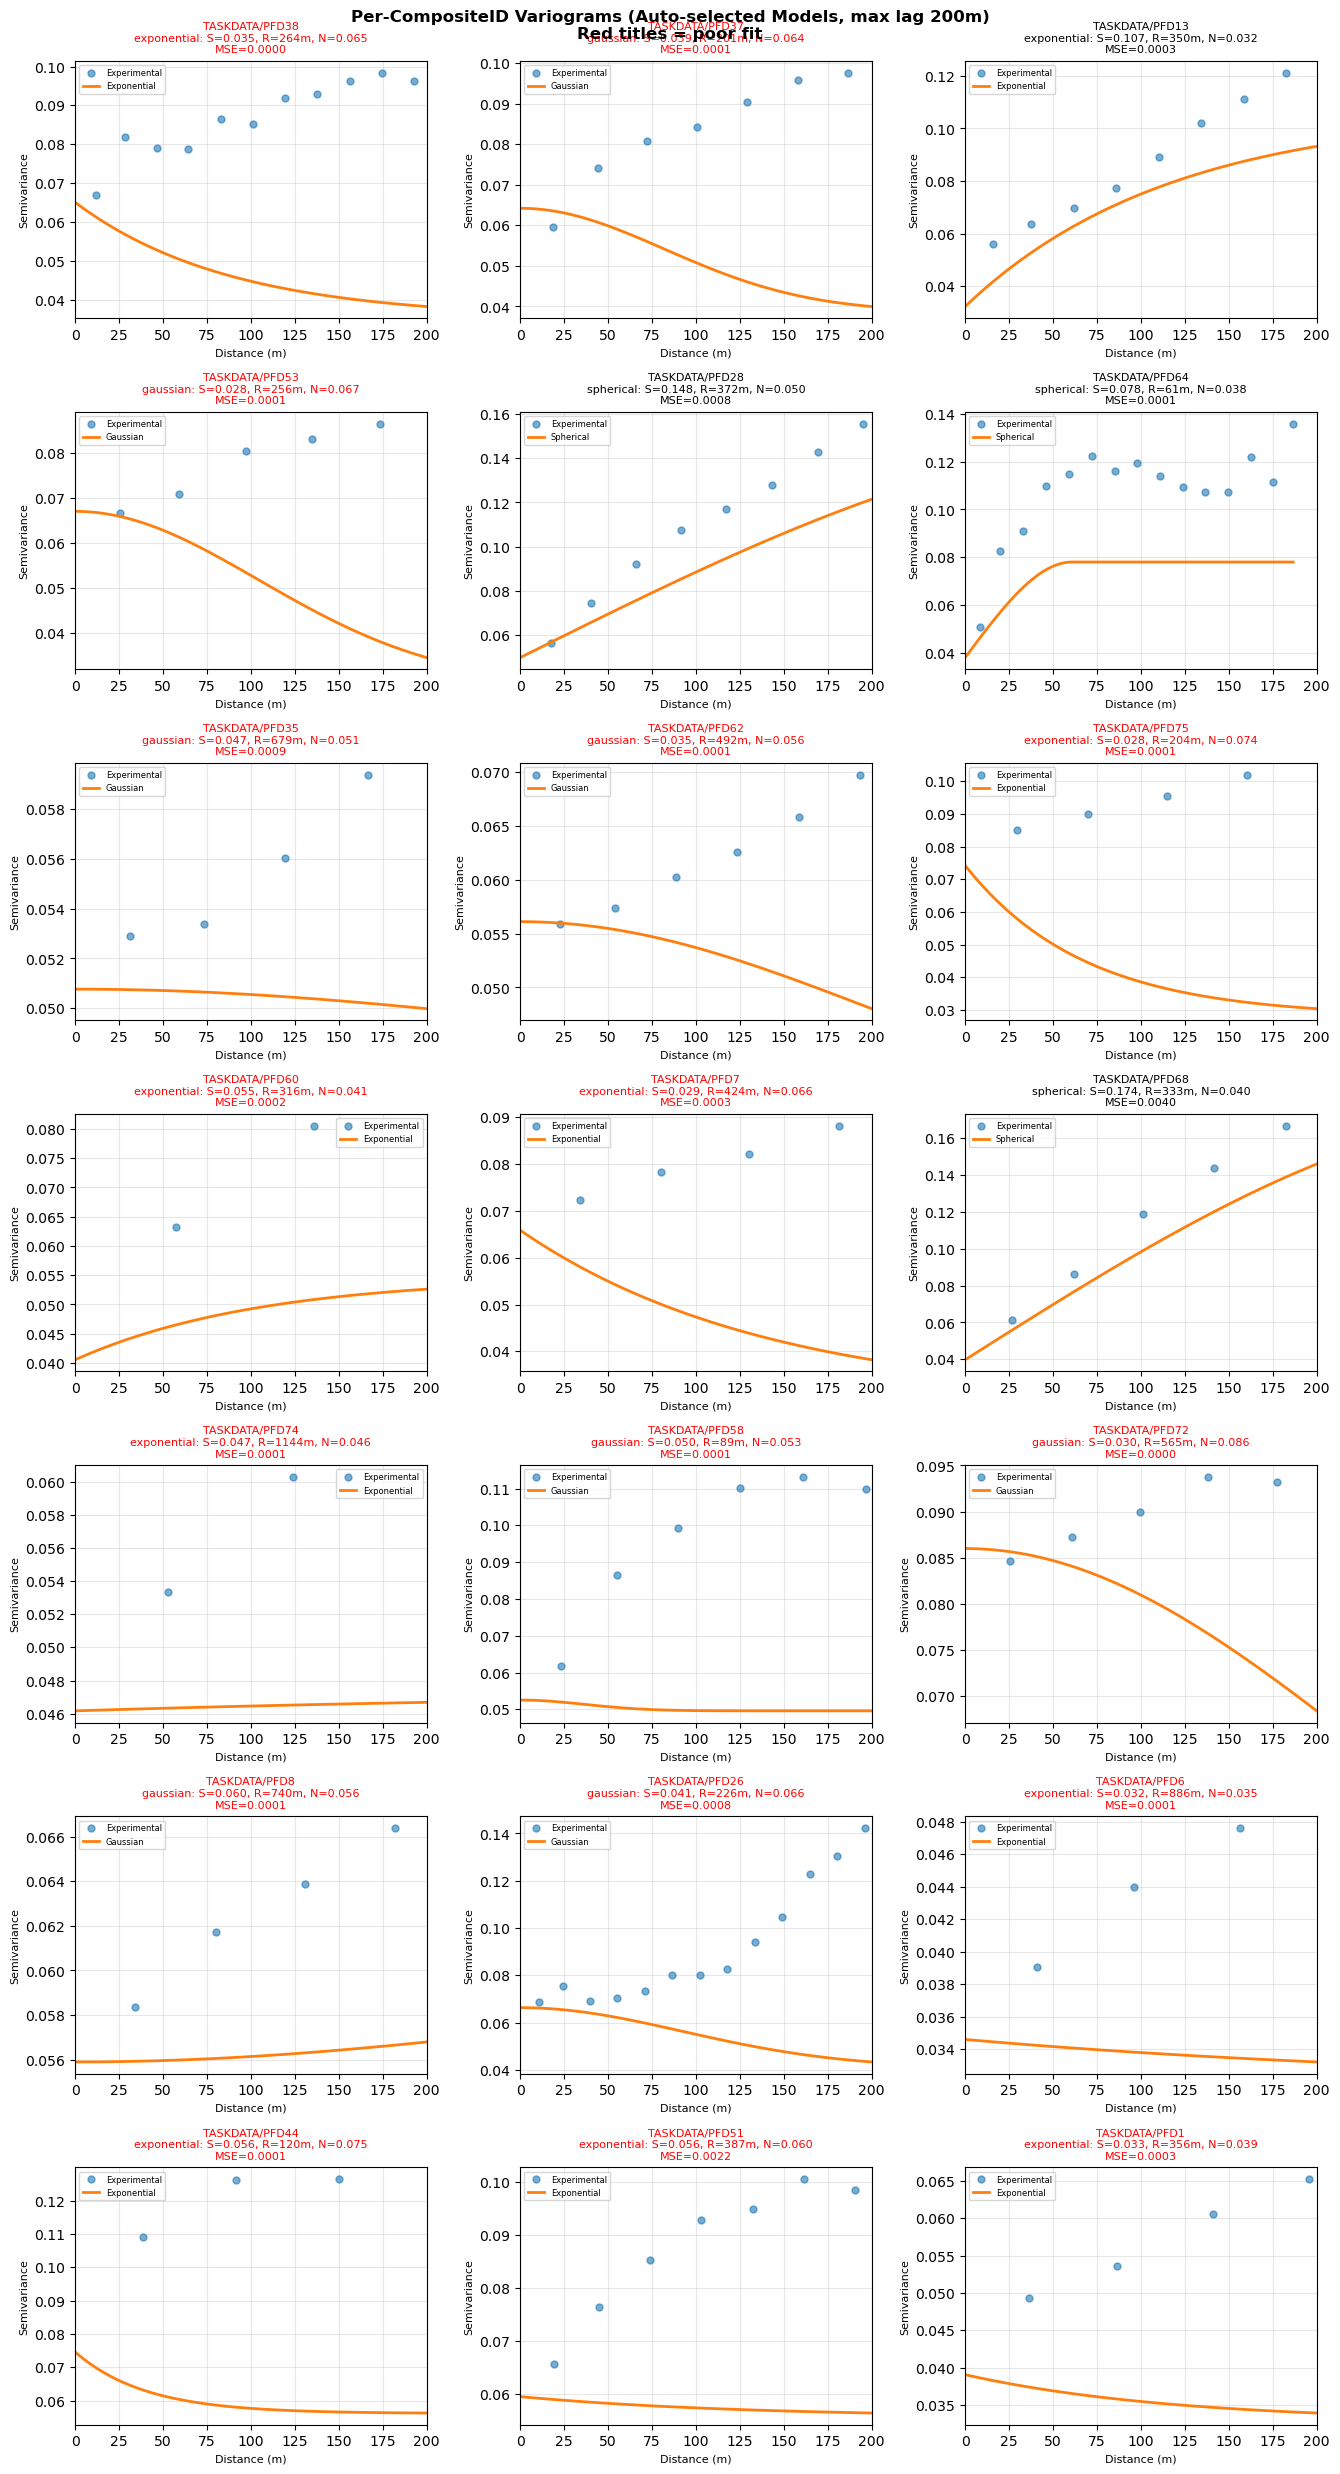


Saved per-CompositeID variogram parameters to /Users/holmes/local_dev/agri_analysis/data/kriging_results/variogram_params_by_composite.csv

⚠ Top 5 poorest fits (check these):
                   CompositeID        model   fit_mse  nugget_ratio  \
TASKDATA/PFD68  TASKDATA/PFD68    spherical  0.003952      0.228875   
TASKDATA/PFD51  TASKDATA/PFD51  exponential  0.002188      1.070457   
TASKDATA/PFD35  TASKDATA/PFD35     gaussian  0.000854      1.072148   
TASKDATA/PFD28  TASKDATA/PFD28    spherical  0.000827      0.336766   
TASKDATA/PFD26  TASKDATA/PFD26     gaussian  0.000751      1.620166   

                points_used  
TASKDATA/PFD68         2508  
TASKDATA/PFD51         1814  
TASKDATA/PFD35         5202  
TASKDATA/PFD28         2268  
TASKDATA/PFD26          734  


In [7]:
# Variogram analysis: CompositeID via polygon intersection (plots + CSV)
# Automatically selects best-fitting variogram model per CompositeID

if not HAS_PYKRIGE:
    print("⚠ Skipping CompositeID variogram - PyKrige not installed")
else:
    # Define variogram helper functions (self-contained cell)
    def compute_spherical_variogram(params, distances):
        """Compute spherical variogram model"""
        sill, range_val, nugget = params
        h = distances / range_val
        # Spherical model: γ(h) = nugget + (sill-nugget) * (1.5*h - 0.5*h³) for h <= 1
        result = np.zeros_like(distances)
        mask = h <= 1.0
        result[mask] = nugget + (sill - nugget) * (1.5 * h[mask] - 0.5 * h[mask]**3)
        result[~mask] = sill
        return result

    def compute_exponential_variogram(params, distances):
        """Compute exponential variogram model"""
        sill, range_val, nugget = params
        return nugget + (sill - nugget) * (1 - np.exp(-3 * distances / range_val))

    def compute_gaussian_variogram(params, distances):
        """Compute gaussian variogram model"""
        sill, range_val, nugget = params
        return nugget + (sill - nugget) * (1 - np.exp(-3 * (distances / range_val)**2))
    
    if not FIELDS_GEOJSON_PATH.exists():
        print(f"❌ Fields GeoJSON not found: {FIELDS_GEOJSON_PATH}")
        print("   Please set FIELDS_GEOJSON_PATH to your field polygon file (GeoJSON, WGS84)")
    else:
        print("\n" + "="*80)
        print("VARIOGRAM ANALYSIS: BY COMPOSITEID (Polygon Intersection)")
        print("="*80)
        print(f"Max lag distance: {MAX_LAG_DISTANCE}m (reasonable given ~17m point spacing)")

        fields_gdf = gpd.read_file(FIELDS_GEOJSON_PATH)
        if fields_gdf.crs is None:
            print("⚠ Polygons have no CRS; assuming WGS84 (GeoJSON default)")
            fields_gdf.set_crs("EPSG:4326", inplace=True)

        # Filter polygons to the target year if available
        if 'Years' in fields_gdf.columns:
            before = len(fields_gdf)
            # Handle both string and numeric Years values
            fields_gdf = fields_gdf[
                (fields_gdf['Years'] == YEAR_TO_RUN) | 
                (fields_gdf['Years'].astype(str) == str(YEAR_TO_RUN))
            ]
            print(f"Filtered polygons to Years={YEAR_TO_RUN}: {len(fields_gdf)} / {before} retained")
            if len(fields_gdf) == 0:
                print("❌ No polygons for the selected year; aborting CompositeID variograms")
        
        # Ensure point CRS and reproject polygons
        if gdf.crs is None:
            gdf.set_crs("EPSG:25832", inplace=True)
        if fields_gdf.crs != gdf.crs:
            print(f"Reprojecting polygons from {fields_gdf.crs} to {gdf.crs}")
            fields_gdf = fields_gdf.to_crs(gdf.crs)

        # Filter points to target year
        pts_year = gdf_valid[gdf_valid['Year'] == YEAR_TO_RUN].copy()
        if 'geometry' not in pts_year.columns or pts_year.geometry.isna().all():
            pts_year = gpd.GeoDataFrame(
                pts_year,
                geometry=gpd.points_from_xy(pts_year['x_utm'], pts_year['y_utm']),
                crs=gdf.crs
            )

        print(f"Points in {YEAR_TO_RUN}: {len(pts_year):,}")
        print(f"Polygons loaded: {len(fields_gdf):,}")
        if FIELD_ID_ATTR not in fields_gdf.columns:
            print(f"❌ Field polygons missing attribute '{FIELD_ID_ATTR}'")
        else:
            joined = gpd.sjoin(
                pts_year[['relative_yield', 'geometry']],
                fields_gdf[[FIELD_ID_ATTR, 'geometry']],
                how='inner',
                predicate='intersects'
            )
            joined.rename(columns={FIELD_ID_ATTR: 'CompositeID'}, inplace=True)
            print(f"Joined points: {len(joined):,}")

            # Stash for reuse in kriging cell
            joined_comp_points = joined
            fields_gdf_comp = fields_gdf[[FIELD_ID_ATTR, 'geometry']].copy()

            comp_ids = joined['CompositeID'].dropna().unique()
            print(f"Found {len(comp_ids)} CompositeIDs to process")

            MIN_POINTS_PER_COMP = 200
            MAX_POINTS_PER_COMP = MAX_VARIOGRAM_POINTS if 'MAX_VARIOGRAM_POINTS' in globals() else 20000

            # Prepare subplots grid
            n_valid = len([cid for cid in comp_ids if len(joined[joined['CompositeID'] == cid]) >= MIN_POINTS_PER_COMP])
            ncols = 3
            nrows = int(np.ceil(n_valid / ncols)) if n_valid > 0 else 1
            fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 3.6*nrows))
            axes = np.array(axes).reshape(-1) if n_valid > 1 else np.array([axes])
            ax_idx = 0

            variogram_params_comp = {}

            # Test models per CompositeID
            models_to_test = ['spherical', 'exponential', 'gaussian']

            for cid in comp_ids:
                sub_pts = joined[joined['CompositeID'] == cid]
                if len(sub_pts) < MIN_POINTS_PER_COMP:
                    print(f"⚠ Skipping {cid} (only {len(sub_pts)} points; need ≥ {MIN_POINTS_PER_COMP})")
                    continue

                x = sub_pts.geometry.x.values
                y = sub_pts.geometry.y.values
                z = sub_pts['relative_yield'].values

                if len(z) > MAX_POINTS_PER_COMP:
                    idx = np.random.choice(len(z), size=MAX_POINTS_PER_COMP, replace=False)
                    x, y, z = x[idx], y[idx], z[idx]

                ax = axes[ax_idx]
                ax_idx += 1

                try:
                    # Calculate lag size to respect MAX_LAG_DISTANCE
                    lag_size = MAX_LAG_DISTANCE / N_LAGS
                    
                    # Try different models and select best fit (lowest MSE)
                    best_model = None
                    best_mse = float('inf')
                    best_ok = None
                    
                    for model in models_to_test:
                        try:
                            ok_test = OrdinaryKriging(
                                x, y, z,
                                variogram_model=model,
                                nlags=N_LAGS,
                                weight=True,
                                enable_plotting=False,
                                verbose=False
                            )
                            # Compute MSE between experimental and fitted variogram
                            exp_var = ok_test.semivariance
                            fitted_var = ok_test.variogram_function(ok_test.variogram_model_parameters, ok_test.lags)
                            mse = np.mean((exp_var - fitted_var)**2)
                            
                            if mse < best_mse:
                                best_mse = mse
                                best_model = model
                                best_ok = ok_test
                        except:
                            continue
                    
                    if best_ok is None:
                        raise Exception("All models failed")
                    
                    params = best_ok.variogram_model_parameters
                    variogram_params_comp[cid] = {
                        'CompositeID': cid,
                        'sill': params[0],
                        'range': params[1],
                        'nugget': params[2],
                        'model': best_model,
                        'points_used': len(z),
                        'fit_mse': best_mse,
                        'nugget_ratio': params[2] / params[0] if params[0] > 0 else 0
                    }

                    # Plot experimental and best-fit model
                    lags = best_ok.lags
                    semivariance = best_ok.semivariance
                    
                    # Only plot lags within MAX_LAG_DISTANCE
                    valid_lags = lags <= MAX_LAG_DISTANCE
                    ax.plot(lags[valid_lags], semivariance[valid_lags], 'o', markersize=5, alpha=0.6, label='Experimental')

                    lag_range = np.linspace(0, min(lags.max(), MAX_LAG_DISTANCE), 100)
                    if best_model == 'spherical':
                        model_values = compute_spherical_variogram(params, lag_range)
                    elif best_model == 'gaussian':
                        model_values = compute_gaussian_variogram(params, lag_range)
                    else:
                        model_values = compute_exponential_variogram(params, lag_range)
                    ax.plot(lag_range, model_values, '-', linewidth=2, label=f'{best_model.capitalize()}')

                    # Color-code title by fit quality
                    nugget_pct = (params[2] / params[0] * 100) if params[0] > 0 else 0
                    title_color = 'red' if best_mse > 0.01 or nugget_pct > 50 else 'black'
                    
                    ax.set_title(
                        f"{cid}\n{best_model}: S={params[0]:.3f}, R={params[1]:.0f}m, N={params[2]:.3f}\nMSE={best_mse:.4f}",
                        fontsize=8,
                        color=title_color
                    )
                    ax.set_xlabel('Distance (m)', fontsize=8)
                    ax.set_ylabel('Semivariance', fontsize=8)
                    ax.set_xlim(0, MAX_LAG_DISTANCE)
                    ax.grid(True, alpha=0.3)
                    ax.legend(fontsize=6)
                    
                    if best_mse > 0.01 or nugget_pct > 50:
                        print(f"⚠ {cid}: Poor fit (MSE={best_mse:.4f}) or high nugget ({nugget_pct:.1f}%)")
                        
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error\n{str(e)[:40]}', ha='center', va='center', fontsize=8, color='red')
                    ax.set_xlabel('Distance (m)', fontsize=8)
                    ax.set_ylabel('Semivariance', fontsize=8)
                    print(f"❌ Variogram failed for {cid}: {e}")

            for j in range(ax_idx, len(axes)):
                axes[j].axis('off')

            plt.suptitle(f'Per-CompositeID Variograms (Auto-selected Models, max lag {MAX_LAG_DISTANCE}m)\nRed titles = poor fit', fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(KRIGING_OUTPUT_DIR / 'variogram_by_composite.png', dpi=150, bbox_inches='tight')
            plt.show()

            if variogram_params_comp:
                df_params = pd.DataFrame.from_dict(variogram_params_comp, orient='index')
                df_params = df_params.sort_values('fit_mse', ascending=False)  # Worst fits first
                df_params.to_csv(KRIGING_OUTPUT_DIR / 'variogram_params_by_composite.csv')
                print(f"\nSaved per-CompositeID variogram parameters to {KRIGING_OUTPUT_DIR / 'variogram_params_by_composite.csv'}")
                print(f"\n⚠ Top 5 poorest fits (check these):")
                print(df_params[['CompositeID', 'model', 'fit_mse', 'nugget_ratio', 'points_used']].head())
            else:
                print("\n❌ No CompositeID variograms computed")


In [8]:
# Kriging: CompositeID via polygon intersection (exponential model)

if not HAS_PYKRIGE:
    print("⚠ Skipping CompositeID kriging - PyKrige not installed")
else:
    fields_gdf = None

    # Reuse polygons from variogram step if available
    if 'fields_gdf_comp' in locals():
        fields_gdf = fields_gdf_comp.copy()
        print("Using cached polygons from variogram step")

    if fields_gdf is None:
        if not FIELDS_GEOJSON_PATH.exists():
            print(f"❌ Fields GeoJSON not found: {FIELDS_GEOJSON_PATH}")
            print("   Please set FIELDS_GEOJSON_PATH to your field polygon file (GeoJSON, WGS84)")
        else:
            fields_gdf = gpd.read_file(FIELDS_GEOJSON_PATH)
            if fields_gdf.crs is None:
                print("⚠ Polygons have no CRS; assuming WGS84 (GeoJSON default)")
                fields_gdf.set_crs("EPSG:4326", inplace=True)
            # Filter polygons to the target year if Years attribute exists
            if 'Years' in fields_gdf.columns:
                before = len(fields_gdf)
                # Handle both string and numeric Years values
                fields_gdf = fields_gdf[
                    (fields_gdf['Years'] == YEAR_TO_RUN) | 
                    (fields_gdf['Years'].astype(str) == str(YEAR_TO_RUN))
                ]
                print(f"Filtered polygons to Years={YEAR_TO_RUN}: {len(fields_gdf)} / {before} retained")
                if len(fields_gdf) == 0:
                    print("❌ No polygons for the selected year; aborting CompositeID kriging")
            # Ensure points have CRS
            if gdf.crs is None:
                gdf.set_crs("EPSG:25832", inplace=True)
            # Reproject polygons to match points (EPSG:25832)
            if fields_gdf.crs != gdf.crs:
                print(f"Reprojecting polygons from {fields_gdf.crs} to {gdf.crs}")
                fields_gdf = fields_gdf.to_crs(gdf.crs)
            fields_gdf_comp = fields_gdf[[FIELD_ID_ATTR, 'geometry']].copy()

    if fields_gdf is None or len(fields_gdf) == 0:
        pass
    else:
        print("\n" + "="*80)
        print("KRIGING INTERPOLATION: BY COMPOSITEID (Polygon Intersection)")
        print("="*80)

        # Filter points to target year
        pts_year = gdf_valid[gdf_valid['Year'] == YEAR_TO_RUN].copy()
        if 'geometry' not in pts_year.columns or pts_year.geometry.isna().all():
            # Ensure geometry exists from x/y
            pts_year = gpd.GeoDataFrame(
                pts_year,
                geometry=gpd.points_from_xy(pts_year['x_utm'], pts_year['y_utm']),
                crs=gdf.crs
            )

        print(f"Points in {YEAR_TO_RUN}: {len(pts_year):,}")
        print(f"Polygons loaded: {len(fields_gdf):,}")
        if FIELD_ID_ATTR not in fields_gdf.columns:
            print(f"❌ Field polygons missing attribute '{FIELD_ID_ATTR}'")
        else:
            if 'joined_comp_points' in locals():
                joined = joined_comp_points
                print("Using cached point-polygon intersection from variogram step")
            else:
                joined = gpd.sjoin(
                    pts_year[['relative_yield', 'geometry']],
                    fields_gdf[[FIELD_ID_ATTR, 'geometry']],
                    how='inner',
                    predicate='intersects'
                )
                joined.rename(columns={FIELD_ID_ATTR: 'CompositeID'}, inplace=True)
            print(f"Joined points: {len(joined):,}")

            # Unique CompositeIDs
            comp_ids = joined['CompositeID'].dropna().unique()
            print(f"Found {len(comp_ids)} CompositeIDs to process")

            kriging_composite_results = {}

            # Performance guard
            MIN_POINTS_PER_COMP = 200
            MAX_COMP_POINTS = 150000

            for cid in comp_ids:
                sub_pts = joined[joined['CompositeID'] == cid]
                if len(sub_pts) < MIN_POINTS_PER_COMP:
                    print(f"  ⚠ Skipping {cid} (only {len(sub_pts)} points; need ≥ {MIN_POINTS_PER_COMP})")
                    continue

                # Get polygon bounds for grid
                poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union
                x_min, y_min, x_max, y_max = poly.bounds

                # Extract arrays
                x = sub_pts.geometry.x.values
                y = sub_pts.geometry.y.values
                z = sub_pts['relative_yield'].values

                # Optional thinning
                if len(z) > MAX_COMP_POINTS:
                    print(f"  ⚠ Thinning {cid}: {len(z):,} → {MAX_COMP_POINTS:,}")
                    idx = np.random.choice(len(z), size=MAX_COMP_POINTS, replace=False)
                    x, y, z = x[idx], y[idx], z[idx]

                grid_x = np.arange(x_min, x_max, GRID_RESOLUTION)
                grid_y = np.arange(y_min, y_max, GRID_RESOLUTION)

                try:
                    ok_comp = OrdinaryKriging(
                        x, y, z,
                        variogram_model=DEFAULT_FIELD_MODEL,
                        nlags=N_LAGS,
                        enable_plotting=False,
                        verbose=False
                    )

                    z_pred, ss_pred = ok_comp.execute('grid', grid_x, grid_y)

                    # Mask predictions to polygon extent
                    Xc, Yc = np.meshgrid(grid_x, grid_y)
                    coords = np.column_stack([Xc.ravel(), Yc.ravel()])
                    from shapely.geometry import Point
                    mask = np.array([poly.contains(Point(px, py)) for px, py in coords])
                    mask = mask.reshape(z_pred.shape)

                    z_pred_masked = np.where(mask, z_pred, np.nan)
                    ss_pred_masked = np.where(mask, ss_pred, np.nan)

                    # Save results
                    kriging_composite_results[cid] = {
                        'z_pred': z_pred_masked,
                        'ss_pred': ss_pred_masked,
                        'grid_x': grid_x,
                        'grid_y': grid_y,
                        'ok_model': ok_comp,
                        'polygon': poly,
                    }

                    # Plot
                    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                    ax = axes[0]
                    im1 = ax.imshow(
                        z_pred_masked,
                        extent=[x_min, x_max, y_min, y_max],
                        origin='lower',
                        cmap='RdYlGn',
                        vmin=0.6,
                        vmax=1.4,
                        aspect='auto'
                    )
                    ax.set_title(f'{cid} - Prediction ({YEAR_TO_RUN})', fontsize=11)
                    plt.colorbar(im1, ax=ax, label='Relative Yield')

                    ax = axes[1]
                    im2 = ax.imshow(
                        ss_pred_masked,
                        extent=[x_min, x_max, y_min, y_max],
                        origin='lower',
                        cmap='viridis',
                        aspect='auto'
                    )
                    ax.set_title(f'{cid} - Variance ({YEAR_TO_RUN})', fontsize=11)
                    plt.colorbar(im2, ax=ax, label='Variance')

                    plt.tight_layout()
                    safe_cid = ''.join(c if (str(c).isalnum() or c in ('-', '_')) else '_' for c in str(cid))
                    fig_path = KRIGING_OUTPUT_DIR / f'kriging_composite_{YEAR_TO_RUN}_{safe_cid}.png'
                    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
                    plt.close(fig)
                    print(f"  ✓ Saved plot: {fig_path.name}")

                except MemoryError:
                    print(f"  ❌ MemoryError for {cid}: increase GRID_RESOLUTION or thin more")
                except Exception as e:
                    print(f"  ❌ Error for {cid}: {str(e)}")

            if kriging_composite_results:
                print(f"\n✓ CompositeID kriging complete: {len(kriging_composite_results)} IDs")
            else:
                print("\n❌ No CompositeID results (see messages above)")


Using cached polygons from variogram step

KRIGING INTERPOLATION: BY COMPOSITEID (Polygon Intersection)
Points in 2025: 131,404
Polygons loaded: 21
Using cached point-polygon intersection from variogram step
Joined points: 131,404
Found 21 CompositeIDs to process


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD38.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD37.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD13.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD53.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD28.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD64.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD35.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD62.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


  ✓ Saved plot: kriging_composite_2025_TASKDATA_PFD75.png


/var/folders/w3/1_ytt14d0w7cyn40yksjj4xm0000gn/T/ipykernel_93512/4180810467.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = fields_gdf[fields_gdf[FIELD_ID_ATTR] == cid].geometry.unary_union


: 

## Section 7: Export Kriging Results

Export the interpolated surfaces as GeoTIFF rasters for use in QGIS or other GIS software.

In [ ]:
# Export kriging results to GeoTIFF

if not HAS_RASTERIO:
    print("⚠ Rasterio not available - skipping GeoTIFF export")
    print("   Install with: pip install rasterio")
elif not HAS_PYKRIGE:
    print("⚠ Kriging not performed - no results to export")
else:
    print("\n" + "="*80)
    print("EXPORTING KRIGING RESULTS")
    print("="*80)
    
    # Export combined model
    if 'kriging_combined_results' in locals():
        z_pred = kriging_combined_results['z_pred']
        grid_x = kriging_combined_results['grid_x']
        grid_y = kriging_combined_results['grid_y']
        
        # Create transform
        transform = from_bounds(
            grid_x.min(), grid_y.min(),
            grid_x.max(), grid_y.max(),
            z_pred.shape[1], z_pred.shape[0]
        )
        
        # Export prediction
        output_path = KRIGING_OUTPUT_DIR / 'kriging_combined_prediction.tif'
        with rasterio.open(
            output_path, 'w',
            driver='GTiff',
            height=z_pred.shape[0],
            width=z_pred.shape[1],
            count=1,
            dtype=z_pred.dtype,
            crs='EPSG:25832',
            transform=transform
        ) as dst:
            dst.write(z_pred, 1)
        
        logger.info(f"Saved combined prediction: {output_path}")
        
        # Export variance
        ss_pred = kriging_combined_results['ss_pred']
        output_path = KRIGING_OUTPUT_DIR / 'kriging_combined_variance.tif'
        with rasterio.open(
            output_path, 'w',
            driver='GTiff',
            height=ss_pred.shape[0],
            width=ss_pred.shape[1],
            count=1,
            dtype=ss_pred.dtype,
            crs='EPSG:25832',
            transform=transform
        ) as dst:
            dst.write(ss_pred, 1)
        
        logger.info(f"Saved combined variance: {output_path}")
    
    # Export yearly models
    if 'kriging_yearly_results' in locals():
        for year, results in kriging_yearly_results.items():
            z_pred = results['z_pred']
            grid_x = results['grid_x']
            grid_y = results['grid_y']
            
            transform = from_bounds(
                grid_x.min(), grid_y.min(),
                grid_x.max(), grid_y.max(),
                z_pred.shape[1], z_pred.shape[0]
            )
            
            # Export prediction
            output_path = KRIGING_OUTPUT_DIR / f'kriging_{year}_prediction.tif'
            with rasterio.open(
                output_path, 'w',
                driver='GTiff',
                height=z_pred.shape[0],
                width=z_pred.shape[1],
                count=1,
                dtype=z_pred.dtype,
                crs='EPSG:25832',
                transform=transform
            ) as dst:
                dst.write(z_pred, 1)
            
            logger.info(f"Saved {year} prediction: {output_path}")
    
    # Export per-field models
    if 'kriging_field_results' in locals():
        for field, results in kriging_field_results.items():
            z_pred = results['z_pred']
            grid_x = results['grid_x']
            grid_y = results['grid_y']
            
            transform = from_bounds(
                grid_x.min(), grid_y.min(),
                grid_x.max(), grid_y.max(),
                z_pred.shape[1], z_pred.shape[0]
            )
            
            safe_field = ''.join(c if (c.isalnum() or c in ('-', '_')) else '_' for c in str(field))
            
            # Export prediction
            output_path = KRIGING_OUTPUT_DIR / f'kriging_field_{safe_field}_prediction.tif'
            with rasterio.open(
                output_path, 'w',
                driver='GTiff',
                height=z_pred.shape[0],
                width=z_pred.shape[1],
                count=1,
                dtype=z_pred.dtype,
                crs='EPSG:25832',
                transform=transform
            ) as dst:
                dst.write(z_pred, 1)
            logger.info(f"Saved field prediction: {output_path}")

            # Export variance
            ss_pred = results['ss_pred']
            output_path = KRIGING_OUTPUT_DIR / f'kriging_field_{safe_field}_variance.tif'
            with rasterio.open(
                output_path, 'w',
                driver='GTiff',
                height=ss_pred.shape[0],
                width=ss_pred.shape[1],
                count=1,
                dtype=ss_pred.dtype,
                crs='EPSG:25832',
                transform=transform
            ) as dst:
                dst.write(ss_pred, 1)
            logger.info(f"Saved field variance: {output_path}")

    # Export CompositeID models
    if 'kriging_composite_results' in locals():
        for cid, results in kriging_composite_results.items():
            z_pred = results['z_pred']
            grid_x = results['grid_x']
            grid_y = results['grid_y']
            
            transform = from_bounds(
                grid_x.min(), grid_y.min(),
                grid_x.max(), grid_y.max(),
                z_pred.shape[1], z_pred.shape[0]
            )
            
            safe_cid = ''.join(c if (str(c).isalnum() or c in ('-', '_')) else '_' for c in str(cid))
            
            # Export prediction
            output_path = KRIGING_OUTPUT_DIR / f'kriging_composite_{YEAR_TO_RUN}_{safe_cid}_prediction.tif'
            with rasterio.open(
                output_path, 'w',
                driver='GTiff',
                height=z_pred.shape[0],
                width=z_pred.shape[1],
                count=1,
                dtype=z_pred.dtype,
                crs='EPSG:25832',
                transform=transform
            ) as dst:
                dst.write(z_pred, 1)
            logger.info(f"Saved composite prediction: {output_path}")

            # Export variance
            ss_pred = results['ss_pred']
            output_path = KRIGING_OUTPUT_DIR / f'kriging_composite_{YEAR_TO_RUN}_{safe_cid}_variance.tif'
            with rasterio.open(
                output_path, 'w',
                driver='GTiff',
                height=ss_pred.shape[0],
                width=ss_pred.shape[1],
                count=1,
                dtype=ss_pred.dtype,
                crs='EPSG:25832',
                transform=transform
            ) as dst:
                dst.write(ss_pred, 1)
            logger.info(f"Saved composite variance: {output_path}")
    
    print(f"\n✓ All kriging results exported to: {KRIGING_OUTPUT_DIR}")
    print(f"\nFiles created:")
    for f in sorted(KRIGING_OUTPUT_DIR.glob('*.tif')):
        print(f"  - {f.name}")
    
    print(f"\n💡 Load these GeoTIFF files in QGIS to visualize the interpolated surfaces.")

## Summary & Next Steps

### Results Summary

This notebook performed kriging interpolation with two approaches:

1. **Combined Model (All Years)**: Uses all data points together, leveraging normalized relative yield
2. **Yearly Models**: Separate kriging for each year to capture temporal variations

### Outputs Created

- Variogram plots showing spatial correlation structure
- Interpolated yield surfaces (GeoTIFF rasters)
- Kriging variance maps (prediction uncertainty)
- Comparison visualizations

### Interpretation Tips

- **High variance areas**: Less data coverage, less reliable predictions
- **Range parameter**: Typical distance of spatial correlation
- **Nugget effect**: Measurement error + micro-scale variation

### Next Steps

1. **Visual inspection**: Load GeoTIFF files in QGIS to compare approaches
2. **Validation**: Use cross-validation to assess prediction accuracy
3. **Comparison**: Decide which approach (combined vs yearly) works better for your data
4. **Management zones**: Use interpolated surfaces to delineate high/low yield zones
5. **Temporal analysis**: Compare yearly surfaces to identify persistent patterns

### Manual Exclusion

If you identified problematic areas (e.g., harvester edge effects), go back to Section 3 and add exclusion criteria based on:
- Field names
- Coordinate ranges
- Relative yield thresholds
- Visual inspection of maps